In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy
from operators.setup_ROM import SimulationSetupROM
from operators.poisson_solver import gmres_solver, fft_solver
from operators.FOM import psi_ln_aw, charge_density
from operators.FOM import total_mass, total_momentum, total_energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Linear Landau Damping AW

In [ ]:
k_ = 0.5
setup = SimulationSetupROM(Nx=100,
                               Nv=20,
                               epsilon=1e-2,
                               alpha_e=np.sqrt(2),
                               alpha_i=np.sqrt(2 / 1836),
                               u_e=0,
                               u_i=0,
                               L=20 * np.pi,
                               dt=1e-1,
                               T0=0,
                               T=20,
                               nu=10,
                               Nr=100,
                               M=3,
                               problem_dir="linear_landau",
                               Ur_e=np.load("../data/ROM/linear_landau/basis_3.npy"),
                               construct=True,
                               ions=False)

In [ ]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [ ]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e5))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx + 1)

# ROM simulation data

In [ ]:
# load the simulation results
sol_u_reduced = np.load("../data/ROM/linear_landau/sample_" + str(k_) + "/M" + str(setup.M) + "/sol_midpoint_u_" + str(setup.Nr) + "_nu_" + str(setup.nu) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/ROM/linear_landau/sample_" + str(k_) + "/M" + str(setup.M) + "/sol_midpoint_t_" + str(setup.Nr) + "_nu_" + str(setup.nu) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

In [ ]:
sol_u_ROM = np.zeros((setup.Nx*setup.Nv, len(sol_midpoint_t)))
sol_u_ROM[:setup.NF, :] = sol_u_reduced[:setup.NF, :]
sol_u_ROM[setup.NF:, :] = setup.Ur_e @ sol_u_reduced[setup.NF:, :]

In [ ]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [ ]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t), 1):
    print("time = ", sol_midpoint_t[ii])
    for n in range(setup.Nv):
        # unwind the flattening to solve the Vlasov-Poisson system
        # electrons
        state_e_midpoint[n, :-1, ii]  = sol_u_ROM[n*setup.Nx: (n+1)*setup.Nx, ii]
        state_e_midpoint[n, -1, ii] = state_e_midpoint[n, 0, ii]

    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i,
                                        q_e=setup.q_e, q_i=setup.q_i,
                                        C0_e=state_e_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [ ]:
# plot the electric field
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/ROM/linear_landau/electric_field_FOM" + str(setup.Nv)+ ".png", dpi=600)

In [ ]:
plt.plot(state_e_midpoint[3, :,:4])

In [ ]:
# compute the electric field k=1 mode amplitude using fft
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

In [ ]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 
ax.plot(sol_midpoint_t, 4e-3*np.exp(-0.153359*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.60776$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../figs/FOM/linear_landau/electric_field_damping_rate_" + str(setup.Nv) + ".png", dpi=600)

In [ ]:
# save the electric field
np.save("../data/ROM/linear_landau/sample_" + str(k_) + "/sol_midpoint_E_" + str(setup.Nr) + "_k_" + str(k_) + ".npy", E_midpoint)
np.save("../data/ROM/linear_landau/sample_" + str(k_) + "/sol_midpoint_E1_" + str(setup.Nr) + "_k_" + str(k_) + ".npy", E1_midpoint)

In [ ]:
# save the electric field
E_coeff_FOM = np.load("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_midpoint_E1_" + str(setup.Nv) + "_k_" + str(k_) + ".npy")
E_coeff_ROM100 = np.load("../data/ROM/linear_landau/sample_" + str(k_) + "/M" + str(setup.M) + "/sol_midpoint_E1_100_k_" + str(k_) + ".npy")
E_coeff_ROM50 = np.load("../data/ROM/linear_landau/sample_" + str(k_) + "/M" + str(setup.M) + "/sol_midpoint_E1_50_k_" + str(k_) + ".npy")
E_coeff_ROM25 = np.load("../data/ROM/linear_landau/sample_" + str(k_) + "/M" + str(setup.M) + "/sol_midpoint_E1_25_k_" + str(k_) + ".npy")

In [ ]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 5.5))
ax.plot(sol_t_ROM, np.abs(E_coeff_FOM[setup.Nx+1]), "--", c="blue", alpha=0.5,  linewidth=3, label=r"FOM")
ax.plot(sol_t_ROM, np.abs(E_coeff_ROM25[setup.Nx+1]), "-", c="green", alpha=0.5,  linewidth=3, label=r"ROM $N_{r}=25$")
ax.plot(sol_t_ROM, np.abs(E_coeff_ROM50[setup.Nx+1]), "-.", c="orange", linewidth=3, label="ROM $N_{r}=50$")
ax.plot(sol_t_ROM, np.abs(E_coeff_ROM100[setup.Nx+1]), ":", c="purple", linewidth=3, label="ROM $N_{r}=100$")
ax.plot(sol_t_ROM, np.exp(-0.309*sol_t_ROM)*6e-3, linewidth=2, color="red", label=r"theory $\gamma = -0.309$") 
ax.axvline(10, ls="--", c="k", alpha=0.5, linewidth=3, label="training ends")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|E_{1}|$")
ax.set_xlabel("$ t$")
ax.set_xticks([0, 10, 20, 30])
ax.set_xlim(0, 30)
legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(1, 1.2))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/electric_field_damping_rate_ROM_" +str(setup.alpha_e) + "_M" + str(setup.M) + ".png", dpi=600)

In [ ]:
RUNTIME100 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_100_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
RUNTIME50 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_50_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
RUNTIME25 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/sol_midpoint_u_25_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]

In [21]:
ERR25 = epsilon_electric(E_ROM=E_coeff_ROM25, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real
ERR50 = epsilon_electric(E_ROM=E_coeff_ROM50, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real
ERR100 = epsilon_electric(E_ROM=E_coeff_ROM100, E_FOM=E_coeff_FOM, Nx=setup.Nx, avg_time=True).real

NameError: name 'epsilon_electric' is not defined

In [22]:
print(ERR25)
print(ERR50)
print(ERR100)

NameError: name 'ERR25' is not defined

In [110]:
EFF25 = 1/(RUNTIME25*ERR25)
EFF50 = 1/(RUNTIME50*ERR50)
EFF100 = 1/(RUNTIME100*ERR100)

In [111]:
np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/efficacy_results_M" + str(setup.M) + ".npy", np.array([EFF25, EFF50, EFF100]))
np.save("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M" + str(setup.M) + "/runtime_results_M" + str(setup.M) + ".npy", np.array([RUNTIME25, RUNTIME50, RUNTIME100]))

In [112]:
EFF3 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M3/efficacy_results_M3.npy")
EFF4 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M4/efficacy_results_M4.npy")
EFF5 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M5/efficacy_results_M5.npy")
RUN3 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M3/runtime_results_M3.npy")
RUN4 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M4/runtime_results_M4.npy")
RUN5 = np.load("../data/ROM/linear_landau/sample_" + str(setup.alpha_e) + "/M5/runtime_results_M5.npy")

In [113]:
FOM_RUNTIME = np.load("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_100_alpha_0.9_runtime_0_30.npy")

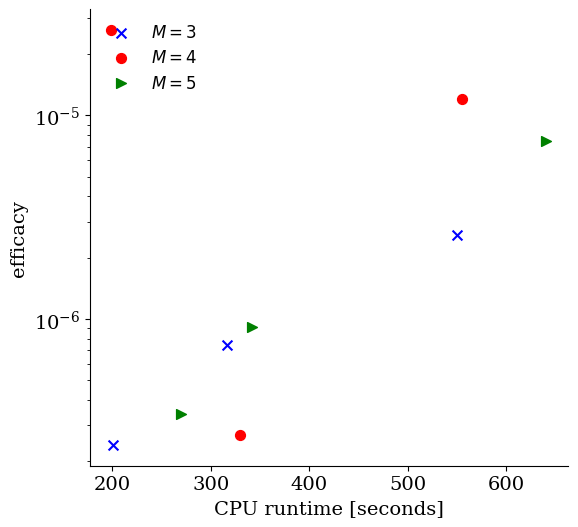

In [114]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 5.5))
ax.scatter(RUN3, EFF3, c="blue", marker="x", s=50, label="$M=3$")
ax.scatter(RUN4, EFF4, c="red", marker="o", s=50, label="$M=4$")
ax.scatter(RUN5, EFF5, c="green", marker=">", s=50, label="$M=5$")
#ax.axvline(FOM_RUNTIME[1], c="k", ls="--", label="FOM CPU runtime")
ax.set_xlabel("CPU runtime [seconds]")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("efficacy")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="upper left")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/weak_landau_efficacy_cpu.png", dpi=600)

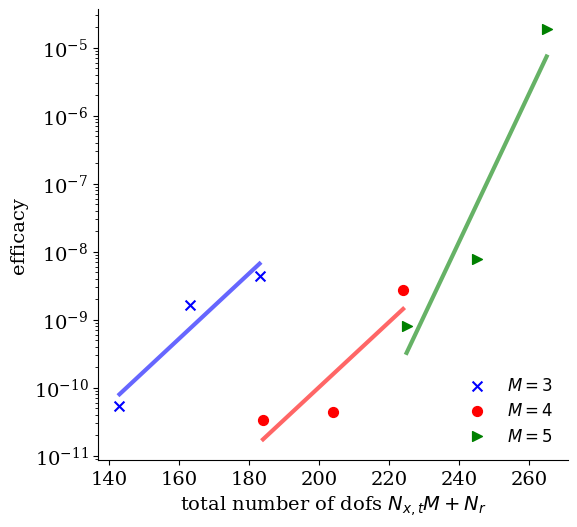

In [73]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 5.5))
ax.scatter((2*setup.Nx+1)*3 + np.array([20, 40, 60]), EFF3, c="blue", marker="x", s=50, label="$M=3$")
ax.scatter((2*setup.Nx+1)*4 + np.array([20, 40, 60]), EFF4, c="red", marker="o", s=50, label="$M=4$")
ax.scatter((2*setup.Nx+1)*5 + np.array([20, 40, 60]), EFF5, c="green", marker=">", s=50, label="$M=5$")

p = np.polyfit((2*setup.Nx+1)*3 + np.array([20, 40, 60]), np.log(EFF3), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*3 + np.linspace(20, 60, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="blue", linewidth=3)


p = np.polyfit((2*setup.Nx+1)*4 + np.array([20, 40, 60]), np.log(EFF4), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*4 + np.linspace(20, 60, 100) 
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="red", linewidth=3)


p = np.polyfit((2*setup.Nx+1)*5 + np.array([20, 40, 60]), np.log(EFF5), deg=1)
a = np.exp(p[1])
b = p[0]
x_fitted = (2*setup.Nx+1)*5 + np.linspace(20, 60, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, alpha=0.6, color="green", linewidth=3)

ax.set_xlabel("total number of dofs $N_{x, t}M + N_{r}$")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("efficacy")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="lower right")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/weak_landau_efficacy.png", dpi=600)

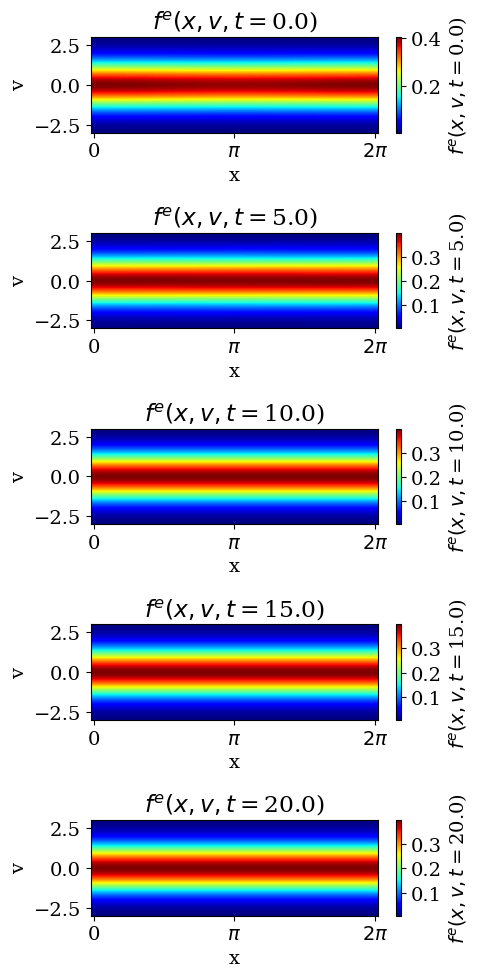

In [28]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_t_ROM), int(len(sol_t_ROM)/4))):
    distribution = np.zeros((Nx_total, len(v)))
    for jj in range(Nv):
        distribution += np.outer(state_e[jj, :, ii], psi_ln_aw((v - u_e)/alpha_e, v=v, alpha_s=alpha_e, u_s=u_e, n=jj))
    pos = ax[tt].pcolormesh(x, v, distribution.T, cmap="jet")
    ax[tt].set_xlabel("x")
    ax[tt].set_xticks([0, np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_t_ROM[ii], 2)) + ")", rotation=90)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(round(sol_t_ROM[ii], 2)) + ")")
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/landau_evolution_" + str(Nv) +".png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [29]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_t_ROM))

for ii in range(0, len(sol_t_ROM)):
    mass_midpoint[ii] = total_mass(psi=sol_u_ROM[:, ii], alpha_e=alpha_e, alpha_i=alpha_i, L=L, Nv=Nv, Nx=Nx).real

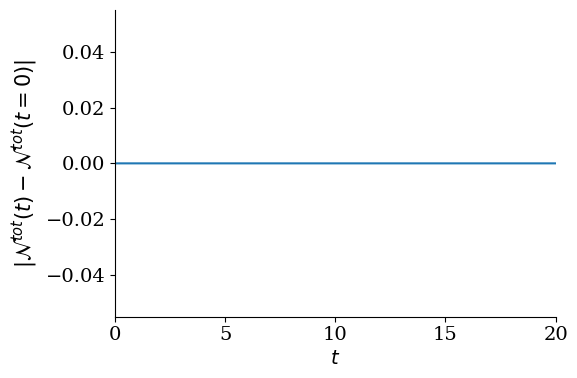

In [30]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_t_ROM, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [31]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_t_ROM))

for ii in range(0, len(sol_t_ROM)):
    momentum_midpoint[ii] = total_momentum(psi=sol_u_ROM[:, ii], alpha_e=alpha_e, alpha_i=alpha_i, 
                                           Nv=Nv, Nx=Nx, L=L, m_i=m_i, m_e=m_e, u_e=u_e, u_i=u_i).real

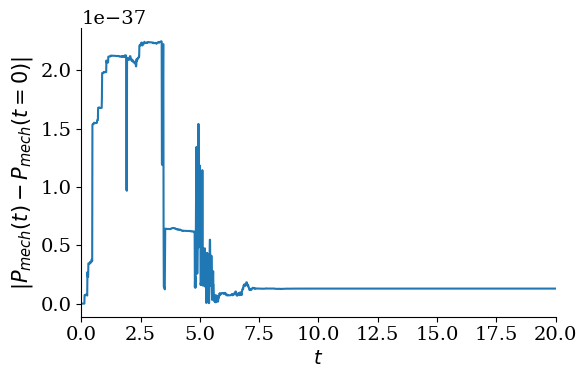

In [32]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_t_ROM, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [33]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_t_ROM))
energy_p_midpoint = np.zeros(len(sol_t_ROM))

for ii in range(0, len(sol_t_ROM)):
    energy_k_midpoint[ii] = total_energy_k(psi=sol_u_ROM[:, ii], alpha_e=alpha_e, alpha_i=alpha_i, 
                                           Nv=Nv, Nx=Nx, L=L, u_e=u_e, u_i=u_i, m_e=m_e, m_i=m_i).real
    
    energy_p_midpoint[ii] = 0.5*L*np.sum(np.abs(E_coeff[:, ii])**2)

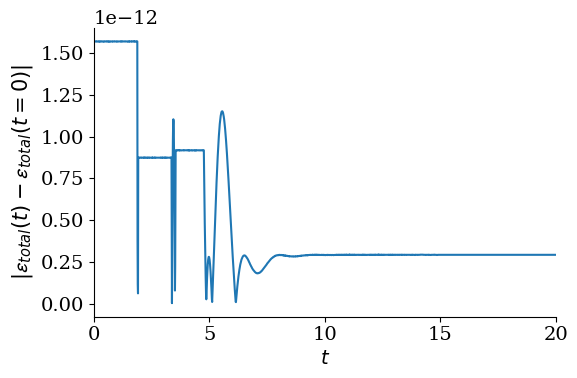

In [34]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_t_ROM, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
#ax.set_yscale("log")
plt.tight_layout()

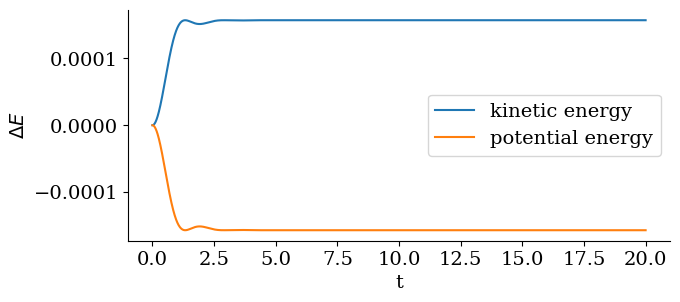

In [35]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_t_ROM, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy")
plt.plot(sol_t_ROM, energy_p_midpoint- energy_p_midpoint[0], label="potential energy")
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

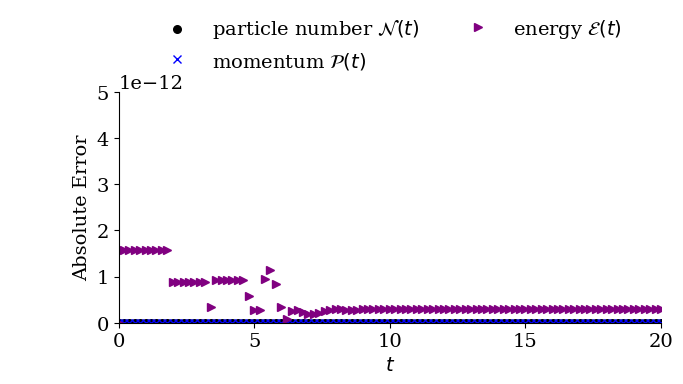

In [44]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_t_ROM[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_t_ROM[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_t_ROM[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_ylim(0, 5*10**-12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_xticks([0, 5, 10, 15, 20])
#ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/ROM/linear_landau/conservation_" + str(Nv) + "_linear_landau__ROM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)

## How does this comparse to the Landau-fluid closures?

Hammert and Perkins closure in Fourier space 
$$ q_{k} \propto i k T_{k}/|k|$$ 
and in real space 
$$
q(x) \propto \int_{0}^{\infty} \mathrm{d} x' \frac{T(x + x') - T(x - x')}{x'}
$$
This closure relates the heat flux to an average nonlocal termperature difference.